In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import linregress
import seaborn as sns
import math

In [ ]:
#olympics_df = pd.read_csv('./archive/Summer-Olympic-medals-1976-to-2008.csv', encoding='latin-1')
olympics_df = pd.read_csv('./archive/athlete_events.csv', encoding='latin-1')
olympics_df.dropna(inplace=True)
olympics_df.drop_duplicates()
olympics_df.head(10)

In [ ]:
countries = olympics_df['Team'].unique()
countries[:10]

In [ ]:
metals = ['Gold', 'Silver', 'Bronze']

nation = []
average_mean = []
trend = []
d_inters = []
std_medals = []
volatility_medals = []
initial_prices = []

for country in countries:
    countryMetals = []
    countryAllMetals = []
    years = []
    country_df = olympics_df[olympics_df['Team'] == country]
    times = country_df['Year'].unique()
    times.sort()
    for time in times:
        years.append(time)
        curYear = country_df[country_df['Year'] == time]
        totalMetals = curYear['Medal'].count()
        countryAllMetals.append(totalMetals)
        golds = curYear[curYear['Medal'] == 'Gold']['Medal'].count()
        silver = curYear[curYear['Medal'] == 'Silver']['Medal'].count()
        bronze = curYear[curYear['Medal'] == 'Bronze']['Medal'].count()
        countryMetals.append([golds,silver, bronze])
    
    if len(countryAllMetals) > 25 and len(years) > 0:
        if years[-1] >= 2008:
            std_dev = np.std(countryAllMetals)
            print("Total mean of Country medals:", sum(countryAllMetals)/len(countryAllMetals))
            print("Total STD of Country medals:", std_dev)
            plt.figure(figsize=(8,4))
            plt.plot(years, countryAllMetals, marker='o')
            plt.xlabel('Year')
            plt.ylabel("Total Medals Earned")
            plt.title(f"Total metals earned by {country} for Summer Olympics")
            plt.show()

            plt.figure(figsize=(8,4))
            plt.plot(years, countryMetals, label=metals)
            plt.legend()
            plt.xlabel('Year')
            plt.ylabel("Total Medals Earned")
            plt.title(f"Total metals earned by {country} for Summer Olympics")
            plt.show()

            plt.figure(figsize=(8,4))
            sns.regplot(x=years, y=countryAllMetals)
            plt.legend()
            plt.xlabel('Year')
            plt.ylabel("Total Medals Earned")
            plt.title(f"Total metals earned by {country} for Summer Olympics")
            plt.show()

            data_med = pd.DataFrame({'year':years, 'Medals':countryAllMetals})
            slope, intercept, r, p, err = linregress(data_med['year'], data_med['Medals'])
            print('Slope of Regression Line', slope)

            #Calculating Volatility
            offset = data_med['Medals'] - (slope * data_med['year'] + intercept)
            volatility = np.std(offset)
            print('Volatility!', volatility, "\n\n")

            nation.append(country)
            average_mean.append(sum(countryAllMetals)/len(countryAllMetals))
            trend.append(slope)
            d_inters.append(intercept)
            std_medals.append(std_dev)
            volatility_medals.append(volatility)
            initial_prices.append(countryAllMetals[-1])

            

## Creating predictions for data above based on the data above


In [ ]:
print(nation)
print(average_mean)
print(trend)
print(d_inters)
print(std_medals)
print(volatility_medals)
print(initial_prices)

## Running a Monte Carlo Prediction on earnings

Reusing the basic shape for the code below but have the variables associated with the work come from the discovered data above. 

In [ ]:


class European_Call_Payoff:

    def __init__(self, strike):
        self.strike = strike

    def get_payoff(self, stock_price):
        if stock_price > self.strike:
            return stock_price - self.strike
        else:
            return 0
# The use of the Brownian motion with the normal distribution made more sense 
class GeometricBrownianMotion:

    def simulate_paths(self):
        while(self.T - self.dt > 0):
            dWt = np.random.normal(0, math.sqrt(self.volatility))  # Brownian motion
            dYt = self.drift*self.current_price*self.dt + self.volatility* self.current_price *dWt  # Change in price (UPDATED)
            self.current_price += dYt  # Add the change to the current price in a logarithmic distribution of growth based on the distributions in the first part.
            self.prices.append(self.current_price)  # Append new price to series
            '''I wanted to add the concept of growing with capping points as this exists in other datasets outside of stocks
            since stocks are usually allowed to grow without bounding
            
            Additionally since the data has both the summer and winter olympics the nummber of metals that can be won swing with the season
            Summer awards a total of 339 Gold medals (depending)
            Winter awards a messley 109 Gold medals (depending)

            From the countries selected above there are 5 that fall into winter strengths and 5 that fall into Summer
            Canada, Sweeden, Finland, Norway and Switzerland 
            
            I was okay leaving volitility unchanged as all I want to mitigate is the natural incline of the system
            '''
            if (self.winterStrong and self.summer) or (self.summer == False and self.winterStrong == False):
                if self.current_price > 40:
                    spin = random.randint(0,3)
                    if spin == 0:
                        self.drift = (.05*self.drift)
                    elif spin == 1:
                        self.drift = (.005*self.drift)
                    else:
                        self.drift = (-.4*self.drift)
                elif self.current_price > self.average_mean + 2:
                    self.drift -= (.2*self.drift)
                elif self.current_price < self.average_mean - 2:
                    self.drift += (.1*self.drift)
            else:
                if self.current_price > 70:
                    spin = random.randint(0,3)
                    if spin == 0:
                        self.drift = (.05*self.drift)
                    elif spin == 1:
                        self.drift = (.005*self.drift)
                    else:
                        self.drift = (-.5*self.drift)
                elif self.current_price > self.average_mean + 5:
                    self.drift -= (.5*self.drift)
                elif self.current_price < self.average_mean - 5:
                    self.drift += (.25*self.drift)
            '''
            End Modification
            '''
            self.T -= self.dt  # Account for the step in time
            self.day += 1

    def __init__(self, initial_price, drift, volatility, average_mean, dt, T, winterStrong, summer):
        self.current_price = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.average_mean = average_mean
        self.dt = dt
        self.T = T
        self.winterStrong = winterStrong
        self.summer = summer
        self.day = 0
        self.prices = [self.current_price]
        self.simulate_paths()

def organizer(paths, initial_price, drift, volatility, average_mean, dt, T, nat, winterStrong, summer):
    price_paths = []

    for i in range(0, paths):
        price_paths.append(GeometricBrownianMotion(initial_price, drift, volatility, average_mean, dt, T, winterStrong, summer).prices)

    call_payoffs = []
    final_prices = []
    #Changed this part of the code to follow the slides MCMC given in 8-11 
    #However there is some confusion as it says that we would need the averages of all of the stocks but we haven't even begun generating Stock a results
    #Because of this I followed the starter code and simply set Sa to 100 and then made the modifications that would be needed for part twos basket question
   
    
    ec = European_Call_Payoff(initial_price)
    
    
    risk_free_rate = 0 # Wasn't defined in the problem description so we will assume 0 for this assignment as I didn't see how to calculate it in the lecture notes
    for price_path in price_paths:
        call_payoffs.append(ec.get_payoff(price_path[-1])/(1 + risk_free_rate))  # We get the last stock price in the series generated to determine the payoff and discount it by one year
        final_prices.append(price_path[-1])

    # Plot the set of generated sample paths
    for price_path in price_paths:
        plt.plot(price_path)
    plt.xlabel('olympic games')
    plt.ylabel('Medals Won')
    plt.title(f"Simulations of Medals won by {nat} Based on Geometric Brownian Motion")
    plt.show()

    print(f"The initial won medals for the {nat} was {initial_price}")
    print(f"Average medal won after {int(1 / dt) * T} olympics: ", round(np.average(final_prices),3))
    print(f'That is a shift of {round(np.average(final_prices) - initial_price, 2)} medals')
    print(f'In other words a/an {round(((np.average(final_prices) - initial_price)*100)/initial_price, 2)}% change in the medals won over the simulated games')

    print("Value in investing", np.average(call_payoffs))


In [ ]:
for ind in range(len(nation)):
    winterStrong = False
    summer = True
    if nation[ind] in ['Canada', 'Sweden', 'Finland', 'Norway', 'Switzerland']:
        winterStrong = True
        print('tru')
    paths = 2000
    initial_pr= initial_prices[ind]
    drift_var = trend[ind]
    volatility = volatility_medals[ind]/100
    aver_meds = average_mean[ind]
    nat = nation[ind]
    #Transforming definition of dt to go over 8 future olympic games. 
    dt = 1/8
    T = 1

    organizer(paths, initial_pr, drift_var, volatility, aver_meds, dt, T, nat, winterStrong, summer)

for ind in range(len(nation)):
    winterStrong = False
    summer = False
    if nation[ind] in ['Canada', 'Sweden', 'Finland', 'Norway', 'Switzerland']:
        winterStrong = True
        print('tru')
    paths = 2000
    initial_pr= initial_prices[ind-1]
    drift_var = trend[ind-1]
    volatility = volatility_medals[ind]/100
    aver_meds = average_mean[ind]
    nat = nation[ind]
    #Transforming definition of dt to go over 8 future olympic games. 
    dt = 1/8
    T = 1

    organizer(paths, initial_pr, drift_var, volatility, aver_meds, dt, T, nat, winterStrong, summer)

# PART 2


### Making Team Based Bandits:: Experimentation and expantion of multi arm Bandit Concept

Having done the above code I wanted to continue my exploration on the maximization concepts. In my proposal I said that my imaginary company could make a country 'gaurentee' their total won golds goes up. I will say that the sent trainer is able to turn 10% of bronze medalists into gold metalists. The goal here is to find the three worst teams and send in this aid. 

In [ ]:
finland_df = olympics_df[olympics_df['Team'] == 'Finland']
finland_df

In [ ]:
fin_sports = finland_df['Sport'].unique()
fin_sports

# Problem 3: The Greatest game of All! debt!

## Despite saying that this is a game it is actually a scheduling problem Solution

Rules of the game:
The game will run for a simulated life of 30 years.
Everyplayer will make the following purchases
- House Payment 
- Car Purchase 

Players or people will have the following as optional items which can occur multiple times.

- Medical Debt
- Credit card Debt
- Personal loans
- more cars


30 different types of player will be used. They will run simulations 1000 times on each style of 
First Come First Serve (FCFS), 2) Shortest-Job-First (SJF) Scheduling, 3) Shortest Remaining Time, 4) Priority Scheduling, and 5) Round Robin Scheduling
This will allow me to understand which style of bill paying results in the most effective payoff system. 

Additionally the items will have the following tagging information:
- Total cost 
- Initial Down Payment
- Intrest Rate
- Payment due

The players themselves will get the following attributes:
- Education
- Income
- Age
- Risk More Debt



Big Purchase Risk Chart

- hs - 4
- a - 3
- b - 2
- ms - 1
- dr - .5

age

- 18-27 - .02
- 28-35 - .03
- 36-45 - .01
- 45+ - .005



In [95]:
def genNewDebt(debtor):
    # Pick type of debt and threshold
    debtType = random.randint(0, 3)
    risk = random.random()
    debtObj = None
    id = random.randint(1,100)
    # Add A Car 
    if debtType == 0:
        if debtor[2] > risk:
            cost = random.randint(20000, 50000) + (1000 * debtor[3])
            initial_dp = random.randint(0,5000)
            interest_rate = random.randint(5,20) - (initial_dp / 1000)
            monthlyPayment = cost / random.choice([24, 36, 48])
            monthlyPayment += monthlyPayment * (interest_rate/100)
                                                                   
            debtObj = {f"Car{id}": [cost, initial_dp, round(interest_rate,2), round(monthlyPayment, 2), 30]}
    # Add Medical Debt
    elif debtType == 1:
        if debtor[2] > risk:
            cost = random.randint(20000, 50000) + (1000 * debtor[3])
            initial_dp = random.randint(0,5000)
            interest_rate = random.randint(5,20) - (initial_dp / 1000)
            monthlyPayment = cost / random.choice([36, 42, 60]) * (interest_rate/100)
            debtObj = {f"Medical{id}": [cost, initial_dp, round(interest_rate,2), round(monthlyPayment, 2), 30]}
    # Add A Credit Card
    elif debtType == 2:
        if debtor[2] > risk:
            cost = random.randint(20000, 50000) + (1000 * debtor[3])
            initial_dp = random.randint(0,5000)
            interest_rate = random.randint(0,20) - (initial_dp / 1000)
            monthlyPayment = cost / random.choice([36, 42, 60]) * (interest_rate/100)
            debtObj = {f"Credit Card{id}": [cost, initial_dp, round(interest_rate,2), round(monthlyPayment, 2), 30]}
    # Add Personal Loan
    else:
        if debtor[2] > risk:
            cost = random.randint(20000, 50000) + (1000 * debtor[3])
            initial_dp = random.randint(0,5000)
            interest_rate = random.randint(0,20) - (initial_dp / 1000)
            monthlyPayment = cost / random.choice([36, 42, 60]) * (interest_rate/100)
            debtObj = {f"Personal Loan{id}": [cost, initial_dp, round(interest_rate,2), round(monthlyPayment, 2), 30]}
        
    return debtObj

In [111]:

def gameLoop(player, playerOwns):
    debtor = player
    playerOwned = playerOwns
    totalDebtLine = []
    numMonthsAlive = 600
    intrestDebtAccrued = 0
    for month in range(numMonthsAlive):
        # Geerating New Debt ensures that the models aren't biased due to Same Pattern of Debt
        objNew = genNewDebt(debtor)
        if not objNew == None:
            playerOwns.update(objNew)
        paid = 0
        '''
        # Implementation of a Simple First Come First Serve Scheduling
        COMPLETED!
        '''
        if debtor[5]=='fcfs':
            while(paid != player[4] and len(playerOwned) > 0):
                firstCome = next(iter(playerOwned))
                if playerOwned[firstCome][0] <= debtor[4]-paid:
                    paid += playerOwned[firstCome][0]
                    del playerOwned[firstCome]
                elif playerOwned[firstCome][0] >= debtor[4]-paid:
                    playerOwned[firstCome][0] -= debtor[4]-paid
                    if playerOwned[firstCome][3] <= debtor[4]-paid:
                        playerOwned[firstCome][4] = 30
                    paid = debtor[4]
        '''
        # Implementation of a Simple Shortest Job First (Least amount to payoff) Scheduling
        COMPLETED!
        '''
        if debtor[5]=='sjf':
            while(paid != player[4] and len(playerOwned) > 0):
                minJob = ''
                minJobSize = 10000000
                for debt in playerOwned:
                    if playerOwned[debt][0] < minJobSize:
                        minJob = debt
                        minJobSize = playerOwned[debt][0]
                if playerOwned[minJob][0] <= debtor[4]-paid:
                    paid += playerOwned[minJob][0]
                    del playerOwned[minJob]
                elif playerOwned[minJob][0] >= debtor[4]-paid:
                    playerOwned[minJob][0] -= debtor[4]-paid
                    if playerOwned[minJob][3] <= debtor[4]-paid:
                        playerOwned[minJob][4] = 30
                    paid = debtor[4]
        '''
        # Implementation of a Simple Priority (Priority based on most pressing due date) Scheduling
        COMPLETED!
        '''
        if debtor[5]=='priority':
            while(paid != player[4] and len(playerOwned) > 0):
                minJob = ''
                minJobSize = 100
                
                for dueDate in playerOwned:
                    if playerOwned[dueDate][-1] < minJobSize:
                        minJob = dueDate
                        minJobSize = playerOwned[dueDate][-1]
                if playerOwned[minJob][0] <= debtor[4]-paid:
                    paid += playerOwned[minJob][0]
                    del playerOwned[minJob]
                elif playerOwned[minJob][0] >= debtor[4]-paid:
                    playerOwned[minJob][0] -= debtor[4]-paid
                    if playerOwned[minJob][3] <= debtor[4]-paid:
                        playerOwned[minJob][4] = 31
                    paid = debtor[4]


        monthDebt = 0
        for itemowned in playerOwned:
            playerOwned[itemowned][-1] -= 1
            #Add interest Every single month and add it again if there is a missed payment
            intrestDebtAccrued += playerOwned[itemowned][3] * (playerOwned[itemowned][3] / 100)
            playerOwned[itemowned][0] += playerOwned[itemowned][3] * (playerOwned[itemowned][3] / 100)
            if playerOwned[itemowned][-1] < 0:
                intrestDebtAccrued += playerOwned[itemowned][3] * (playerOwned[itemowned][3] / 100)
                playerOwned[itemowned][0] += playerOwned[itemowned][3] * (playerOwned[itemowned][3] / 100)
            playerOwned[itemowned][0] = round(playerOwned[itemowned][0],2)
            
            monthDebt += playerOwned[itemowned][0]

        totalDebtLine.append(monthDebt)


    return totalDebtLine, intrestDebtAccrued   


In [134]:
import copy

player = ['b', '34', .02, 34, 5000, 'priority']
playerOwns = {'House': [270000, 14000, 5.6, 500, 30], 'Car': [32000, 4000, 7.8, 344, 30]}


total_Table = []
total_Tax = []

for i in range(10):
    print(playerOwns)
    debtor = copy.deepcopy(player)
    playerOwned = copy.deepcopy(playerOwns)
    totalDebt, intrestcost = gameLoop(debtor, playerOwned)
    
    if len(total_Table) == 0:
        for j in range(len(totalDebt)):
            total_Table.append(totalDebt[j])
    for l in range(len(totalDebt)):
        total_Table[l] += totalDebt[l]
    total_Tax.append(intrestcost) 



{'House': [270000, 14000, 5.6, 500, 30], 'Car': [32000, 4000, 7.8, 344, 30]}
{'House': [4217.28, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [3434.56, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [2651.84, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [4369.12, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [3586.4, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [2803.68, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [4520.96, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [3738.24, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}
{'House': [2955.52, 14000, 5.6, 500, 30], 'Car': [4217.28, 4000, 7.8, 344, 29]}


855169193.0784997


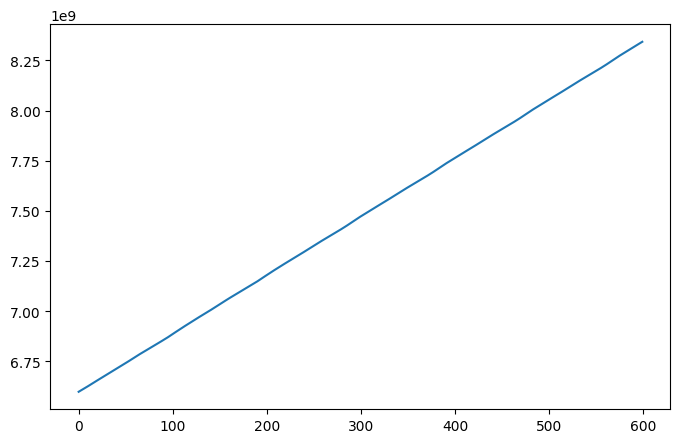

In [109]:
plt.figure(figsize=(8,5))
plt.plot(totalDebt)
print(sum(total_Tax)/len(total_Tax))